In [14]:
# External imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import corner
import seaborn as sns
sns.set_theme()
import arviz as az

import pymc3 as pm 
import theano.tensor as tt

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

#### Import data from file
Split data into full $z$-range and low-$z$-range ($z<0.5$, prefixed with 'low_').

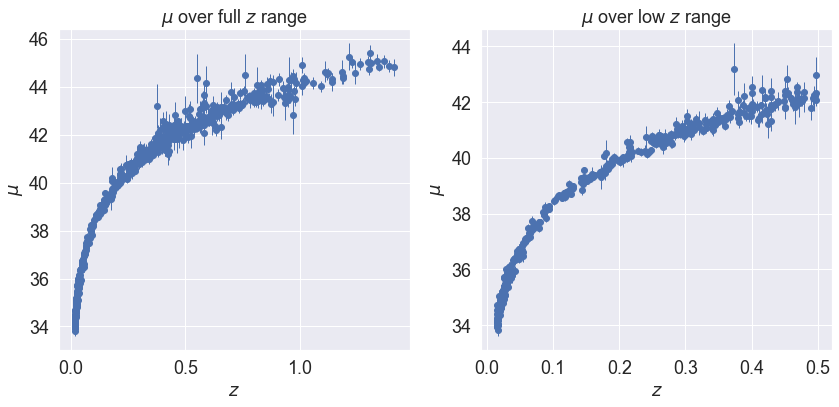

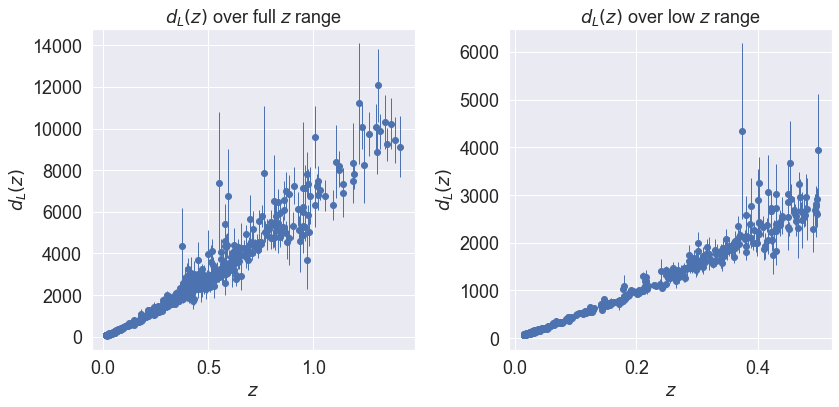

In [20]:
### Imported data
z = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 1)
mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 2)
delta_mu = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 3)
data4 = np.loadtxt("SCPUnion2.1_mu_vs_z.txt", skiprows = 5, delimiter = "\t",usecols = 4)

### Sort data for increasing z
sortOrder = np.argsort(z)
z = z[sortOrder]
mu = mu[sortOrder]
delta_mu = delta_mu[sortOrder]
dl = 10**(mu/5-5) # Extract dl(z) from modulus
delta_dl = dl*np.log(10)*delta_mu/5

### Extract low-z-range
low_ind = np.where(z<0.5)
low_z = z[low_ind]
low_mu = mu[low_ind]
low_delta_mu = delta_mu[low_ind]

low_dl = 10**(low_mu/5-5)
low_delta_dl = low_dl*np.log(10)*low_delta_mu/5

### Plot the data
fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,mu)
ax[0].errorbar(z,mu,delta_mu, linewidth = 0, elinewidth = 1)

ax[1].scatter(low_z,low_mu)
ax[1].errorbar(low_z,low_mu,low_delta_mu, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$\mu$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$\mu$')
ax[1].set_title(r'$\mu$ over low $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$\mu$')
plt.tight_layout()


fig,ax = plt.subplots(1,2, figsize = (12,6))
ax[0].scatter(z,dl)
ax[0].errorbar(z,dl,delta_dl, linewidth = 0, elinewidth = 1)
ax[1].scatter(low_z,low_dl)
ax[1].errorbar(low_z,low_dl,low_delta_dl, linewidth = 0, elinewidth = 1)
ax[0].set_title(r'$d_L(z)$ over full $z$ range')
ax[0].set_xlabel(r'$z$')
ax[0].set_ylabel(r'$d_L(z)$')
ax[1].set_title(r'$d_L(z)$ over low $z$ range')
ax[1].set_xlabel(r'$z$')
ax[1].set_ylabel(r'$d_L(z)$')

plt.tight_layout()

#### Define model
Defines models for $\mu$ and $d_L(z)$, introducing our parameters (random variables) $H_0$ and $q_0$. Note that we set  $c=1$ here, i.e. $c$ is baked into the value for $H_0$. In the treatment below we call this value $\theta = \frac{H_0}{c}$.

In [23]:
c = 1
def mu_model(z, H0, q0):
    return np.log10(dl_model(z,H0,q0))*5 + 25
    
def dl_model(z, H0, q0):
    return c/H0*(z + 1/2*(1-q0)*z**2)

#### PyMC3 setup - Define priors and likelihood
Defines our PyMC3 models. We use uniform priors for $H_0$ and $q_0$. We use 

$$ 
    \theta \sim \mathcal{U}(0, 0.01) \\
    q_0 \sim \mathcal{U}(-100, 100)
$$

We also introduce a weight matrix $\mathbf{W}$, to weight each datapoint according to its associated error. $\mathbf{W}$ is normalized so that $\sum_i w_i = N_d$ where N_d is the number of datapoints. $\mathbf{W}$ is then inverted to obtain a matrix proportional to the covariance $\Sigma$, but since we do not know the absolute overall scale we introduce an error scale parameter $\sigma^2$, with an inverse gamma prior distribution:

$$
    \sigma^2 \sim \mathcal{IG}(\alpha=1,\beta=1)
$$
Finally, since we deal with heteroscedastic errors (hence the covariance matrix) we need to use a multivariate normal distribution in our likelihood, which we then write as

$$
    p(\mathcal{D}|\theta, q_0, \sigma^2, I) = \frac{1}{\sqrt{(2 \pi)^{N_d} |\Sigma|}} \exp{\left(-\frac{1}{2} \left(\mathbf{\hat{y}} - \mathcal{D} \right)^T \Sigma^{-1} \left(\mathbf{\hat{y}} - \mathcal{D} \right)\right)} \\
    \Sigma = \sigma^2 \mathbf{W}^{-1}
$$
where $\mathcal{D}$ are the collected values for $d_L(z)$, and $\mathbf{\hat{y}}$ is our model output at the same $z$-values that $\mathcal{D}$ is sampled at.

In [26]:
W = np.diag(low_delta_mu**(-2))
W_dl = len(low_z)*(low_delta_dl**(-2))/((low_delta_dl**(-2)).sum())
cov = np.diag(1/W_dl)
 
our_mu_model = pm.Model()
with our_mu_model:
    

    #H0 = pm.Uniform("H0", lower = -10, upper = 10, shape = 1)
    theta = pm.Uniform("theta", lower = 10, upper = 10000, shape = 1) # theta = 1/H0
    q0 = pm.Uniform("q0", lower = -100, upper = 100, shape = 1)
    
    sigma2 = pm.InverseGamma("sigma2", 1, 1)
    
    dl = c*theta*(low_z + 1/2*(1-q0)*low_z**2)
    mu_m = np.log10(dl)*5 + 25

    #mu_obs = pm.Normal('mu_obs', mu=mu_m, sd=tt.sqrt(sigma2), observed=low_mu)
    mu_obs = pm.MvNormal('mu_obs', mu=mu_m, cov= sigma2*np.diag(low_delta_mu**2), observed=low_mu)
    

    
our_dl_model = pm.Model()
with our_dl_model:
    # Priors for model parameters and scale parameter sigma
    theta = pm.Uniform("theta", lower = 0, upper = 0.01, shape = 1)
    q0 = pm.Uniform("q0", lower = -100, upper = 100, shape = 1)
    sigma2 = pm.InverseGamma("sigma2", 1, 1)

    # Model output given our distributions for theta, q0 and sigma2
    dl = 1/theta*(low_z + 1/2*(1-q0)*low_z**2)    
    dl_obs = pm.MvNormal('dl_obs', mu=dl, cov=sigma2*cov, observed=low_dl)

In [31]:
### MAP estimate
# Perform as a first check
map_estimate = pm.find_MAP(model=our_dl_model)

theta = map_estimate['theta'][0]
q0 = map_estimate['q0'][0]
s2  = map_estimate['sigma2']

print(f'theta = {theta:.6f} => H0 = {theta*299792458} \nq0 = {q0:.3f}\nsigma2 = {s2:.3f}')

logp = -2,136.5, ||grad|| = 986.75: 100%|███████████████████████████████████████████| 38/38 [00:00<00:00, 57.32it/s]

theta = 0.000234 => H0 = 70254.77762162361 
q0 = -0.409
sigma2 = 177.074


#### Sample posterior using NUTS

In [ ]:
with our_dl_model:
    trace_NUTS = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\ericl\miniconda3\envs\ml\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\ericl\miniconda3\envs\ml\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma2, q0, theta]
Sampling 2 chains, 0 divergences:   0%|                         

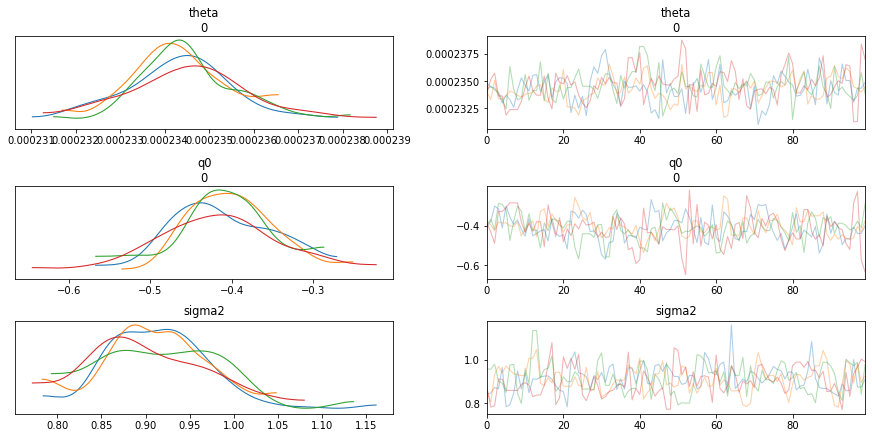

In [237]:
with our_dl_model:
    az.plot_trace(trace_NUTS);

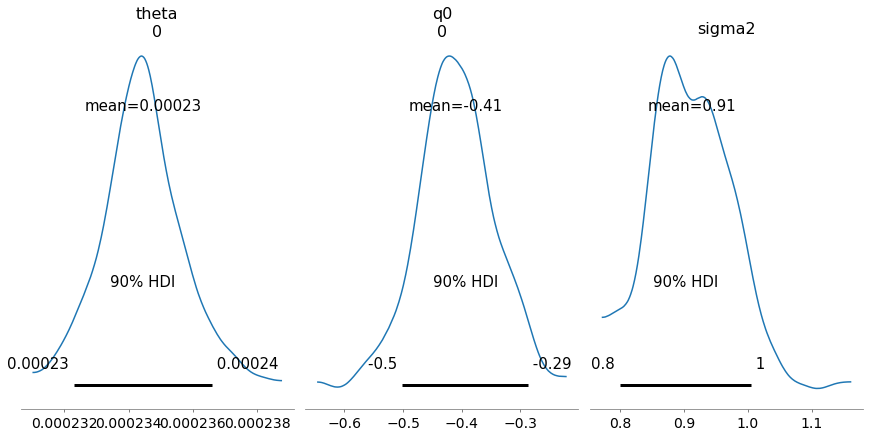

In [238]:
# or plot only marginalized posteriors with some mean and highest_density_intervals
with our_dl_model:
    az.plot_posterior(trace_NUTS,figsize=(12, 6),hdi_prob=0.9);

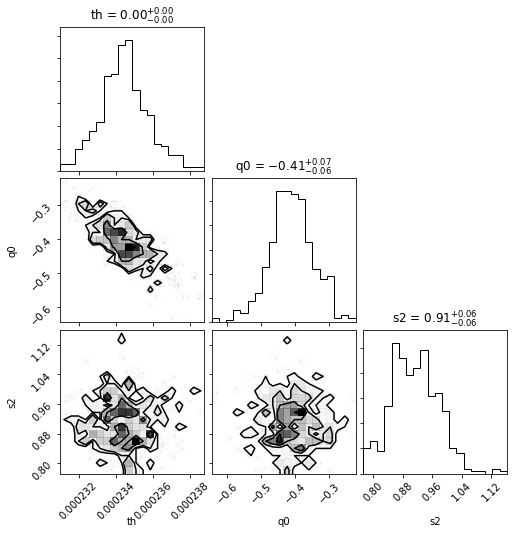

In [239]:
# you can stack the traces and plot them using corner

#samples = np.vstack([trace_NUTS['theta'][:,k] for k in range(0,len(trace_NUTS['theta'][0]))])
samples = np.vstack(trace_NUTS['theta'][:]).T
samples = np.vstack((samples,trace_NUTS['q0'][:].T))
samples = np.vstack((samples,(trace_NUTS['sigma2'][:]).T)).T

fig_corner = corner.corner(samples,labels =['th', 'q0','s2'],show_titles=True);

#### Posterior predictive plot
Perform a posterior predictive plot using the samples from the posterior. 

/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


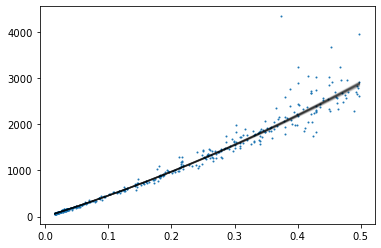

In [241]:
with our_dl_model:
    posterior_draws = pm.sample_posterior_predictive(trace_NUTS, var_names=["theta", "q0", "sigma2"], 
                                                     samples=40, random_seed=123);

for idx, theta_sample in enumerate(posterior_draws['theta']):
    epsilon = np.random.normal(scale=np.sqrt(posterior_draws['sigma2'][idx]))
    plt.plot(low_z, dl_model(low_z, theta_sample,posterior_draws['q0'][idx]) + epsilon,color='black',alpha=0.05)
plt.scatter(low_z,low_dl, s = 1)